<a href="https://colab.research.google.com/github/lucamachado49/Modelos-de-Regressao-Linear/blob/main/VaR_e_GARCH_Petr%C3%B3leo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 41.6 MB/s eta 0:00:00


In [ ]:
# Importação das bibliotecas necessárias
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as stats
from arch import arch_model

In [ ]:
# 1. Coleta de Dados
def baixar_dados(ticker, inicio, fim):
    """
    Baixa dados históricos de um ativo usando yfinance.
    """
    dados = yf.download(ticker, start=inicio, end=fim)
    if 'Adj Close' in dados.columns:
        return dados['Adj Close']
    elif 'Close' in dados.columns:
        return dados['Close']
    else:
        raise KeyError(f"A coluna 'Adj Close' ou 'Close' não está disponível para {ticker}. Dados retornados: {dados.columns}")

# Baixar dados do petróleo Brent (BZ=F)
dados_petroleo = baixar_dados('BZ=F', '2000-01-01', '2023-01-01')

[*********************100%***********************]  1 of 1 completed


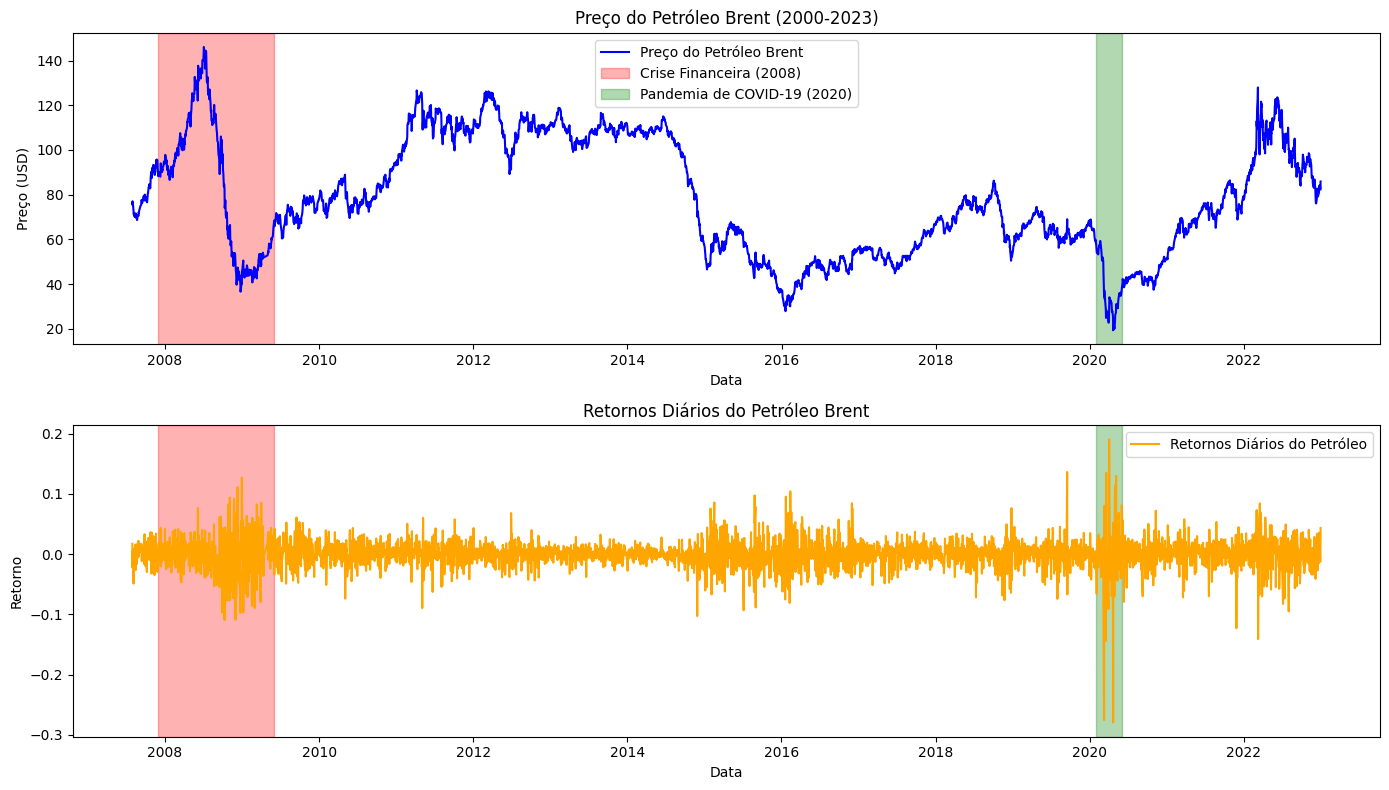

In [ ]:
# 2. Análise Exploratória
def calcular_retornos(dados):
    """
    Calcula os retornos logarítmicos diários.
    """
    return np.log(dados / dados.shift(1)).dropna()

retornos_petroleo = calcular_retornos(dados_petroleo)

# Visualização dos preços e retornos
plt.figure(figsize=(14, 8))

# Gráfico dos preços do petróleo
plt.subplot(2, 1, 1)
plt.plot(dados_petroleo, label='Preço do Petróleo Brent', color='blue')
plt.axvspan('2007-12-01', '2009-06-01', color='red', alpha=0.3, label='Crise Financeira (2008)')
plt.axvspan('2020-02-01', '2020-06-01', color='green', alpha=0.3, label='Pandemia de COVID-19 (2020)')
plt.title('Preço do Petróleo Brent (2000-2023)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()

# Gráfico dos retornos do petróleo
plt.subplot(2, 1, 2)
plt.plot(retornos_petroleo, label='Retornos Diários do Petróleo', color='orange')
plt.axvspan('2007-12-01', '2009-06-01', color='red', alpha=0.3)
plt.axvspan('2020-02-01', '2020-06-01', color='green', alpha=0.3)
plt.title('Retornos Diários do Petróleo Brent')
plt.xlabel('Data')
plt.ylabel('Retorno')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 3. Análise de Eventos de Estresse
def analisar_periodo(dados, retornos, inicio, fim, nome_periodo):
    """
    Analisa um período específico, calculando estatísticas descritivas.
    """
    periodo_dados = dados.loc[inicio:fim]
    periodo_retornos = retornos.loc[inicio:fim]

    # Converte para float caso seja um Series
    preco_medio = float(periodo_dados.mean())
    volatilidade = float(periodo_retornos.std())
    drawdown_maximo = float(periodo_dados.min() / periodo_dados.max() - 1)

    print(f"\nAnálise do Período: {nome_periodo} ({inicio} a {fim})")
    print(f"Preço Médio: {preco_medio:.2f}")
    print(f"Volatilidade (Desvio Padrão dos Retornos): {volatilidade:.4f}")
    print(f"Drawdown Máximo: {drawdown_maximo:.2%}")

# Crise Financeira de 2008
analisar_periodo(dados_petroleo, retornos_petroleo, '2007-12-01', '2009-06-01', 'Crise Financeira (2008)')

# Pandemia de COVID-19 (2020)
analisar_periodo(dados_petroleo, retornos_petroleo, '2020-02-01', '2020-06-01', 'Pandemia de COVID-19 (2020)')



Análise do Período: Crise Financeira (2008) (2007-12-01 a 2009-06-01)
Preço Médio: 86.43
Volatilidade (Desvio Padrão dos Retornos): 0.0349
Drawdown Máximo: -74.94%

Análise do Período: Pandemia de COVID-19 (2020) (2020-02-01 a 2020-06-01)
Preço Médio: 36.59
Volatilidade (Desvio Padrão dos Retornos): 0.0721
Drawdown Máximo: -67.41%


<ipython-input-9-b7fcdb02f6f9>:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preco_medio = float(periodo_dados.mean())
<ipython-input-9-b7fcdb02f6f9>:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volatilidade = float(periodo_retornos.std())  # Correção aqui
<ipython-input-9-b7fcdb02f6f9>:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  drawdown_maximo = float(periodo_dados.min() / periodo_dados.max() - 1)


In [ ]:
# 4. Cálculo do VaR

# a. VaR Histórico
def calcular_var_historico(retornos, nivel_confianca=0.95):
    """
    Calcula o VaR histórico com base nos retornos.
    """
    return np.percentile(retornos, 100 * (1 - nivel_confianca))

var_historico = calcular_var_historico(retornos_petroleo)
print(f"\nVaR Histórico (95%): {var_historico:.4f}")

# b. VaR Paramétrico (Distribuição Normal)
def calcular_var_paramétrico(retornos, nivel_confianca=0.95):
    """
    Calcula o VaR paramétrico assumindo distribuição normal.
    """
    media = retornos.mean()
    desvio_padrao = retornos.std()
    z_score = stats.norm.ppf(1 - nivel_confianca)
    return media + z_score * desvio_padrao

var_paramétrico = calcular_var_paramétrico(retornos_petroleo)
print(f"VaR Paramétrico (95%): {var_paramétrico.iloc[0]:.4f}")

# c. VaR por Simulação de Monte Carlo
def simular_monte_carlo(retornos, dias=252, simulacoes=10000, nivel_confianca=0.95):
    """
    Simula cenários futuros usando o método de Monte Carlo.
    """
    media = retornos.mean()
    desvio_padrao = retornos.std()
    retornos_simulados = np.random.normal(media, desvio_padrao, (dias, simulacoes))
    retornos_acumulados = np.cumprod(1 + retornos_simulados, axis=0) - 1
    var_monte_carlo = np.percentile(retornos_acumulados[-1, :], 100 * (1 - nivel_confianca))
    return var_monte_carlo

var_monte_carlo = simular_monte_carlo(retornos_petroleo)
print(f"VaR Monte Carlo (95%): {var_monte_carlo:.4f}")


VaR Histórico (95%): -0.0377
VaR Paramétrico (95%): -0.0402
VaR Monte Carlo (95%): -0.5016


In [ ]:
# 5. Backtesting
def backtest_var(retornos, var, nivel_confianca=0.95):
    """
    Avalia a precisão do modelo VaR comparando com os retornos reais.
    """
    violacoes = retornos < var
    taxa_violacoes = violacoes.mean()

    print(f"Taxa de Violações do VaR: {taxa_violacoes.item():.4f} (esperado: {1 - nivel_confianca})")


# Backtest para o VaR Histórico
backtest_var(retornos_petroleo, var_historico)



Taxa de Violações do VaR: 0.0501 (esperado: 0.050000000000000044)


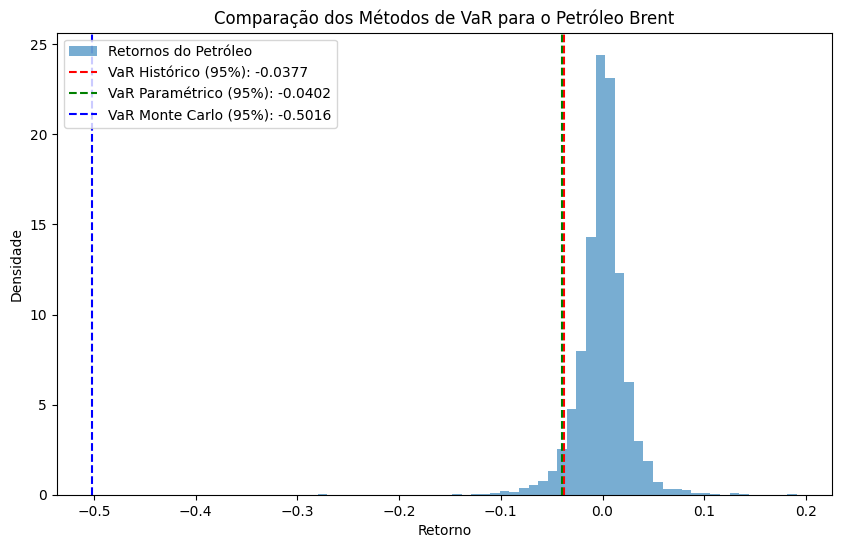

In [ ]:
# 6. Visualizações
# Gráfico comparativo dos métodos de VaR
plt.figure(figsize=(10, 6))
plt.hist(retornos_petroleo, bins=50, density=True, alpha=0.6, label='Retornos do Petróleo')
plt.axvline(var_historico, color='r', linestyle='--', label=f'VaR Histórico (95%): {var_historico:.4f}')
plt.axvline(var_paramétrico.iloc[0], color='g', linestyle='--', label=f'VaR Paramétrico (95%): {var_paramétrico.iloc[0]:.4f}') # Access the first element of the Series
plt.axvline(var_monte_carlo, color='b', linestyle='--', label=f'VaR Monte Carlo (95%): {var_monte_carlo:.4f}')
plt.title('Comparação dos Métodos de VaR para o Petróleo Brent')
plt.xlabel('Retorno')
plt.ylabel('Densidade')
plt.legend()
plt.show()